In [ ]:

from utils import *

data_path = '/workspaces/Flow/data'
patients = [pat.split('/')[-1] for pat in glob.glob(f'{data_path}/*')] 

model_name = 'FLOW-3'
version = 'v5_test'
results_path = f'results/{version}' 


def read_dicom_header(dicom_files, series):
    '''
    read the information we want from the header and assert that the series has to have pixelarray data
    '''
    dicoms_in_series = dicom_files[series]
    dicom_info = {}
    for dicom_path in dicoms_in_series: # go through dicom in each series
        dcm = pydicom.dcmread(dicom_path, force=True) # read dicom

        try: # if dicom doesn't have an associate pixel array (image), ignore dicom
            image = dcm.pixel_array  
            image_exists = True
            if image.ndim == 3: # ignore dicom if 3d
                image_exists = False
            try:
                if dcm.MRAcquisitionType == '3D': # ignore dicom if 3d
                    image_exists = False
                    break
            except:
                pass

        except Exception as e:
            print('error reading image', e)
            image_exists = False
            break

        if image_exists: # if image exists and is not 3d read all other information
            dicom_info[dicom_path] = {}
            image = dcm.pixel_array.astype('float32')
            try:
                intercept = dcm.RescaleIntercept
                slope = dcm.RescaleSlope
            except:
                try:
                    intercept = list(dcm.RealWorldValueMappingSequence)[0].RealWorldValueIntercept 
                    slope = list(dcm.RealWorldValueMappingSequence)[0].RealWorldValueSlope 
                except:
                    intercept = 1
                    slope = 1
            image = image * slope + intercept # true pixel values from dicom
            manufacturer = dcm.Manufacturer.lower()
            
            # initialise some variables
            venc = 0
            scale = 1
            vas_flag = 0
            
            if 'siemens' in manufacturer:
                try:
                    venc = str(dcm[0x0051, 0x1014]._value)
                    numbers = re.findall(r'\d+', venc)
                    venc = float(max(list(map(int, numbers))))
                except:
                    try:
                        venc = str(dcm[0x0018, 0x0024]._value)
                        venc = float(re.search(r'v(\d+)in', venc).group(1))
                    except:
                        venc = 0
                image = image.astype('float32')
                if venc > 0:
                    image = (image * venc)/4096
                    
            if 'ge' in manufacturer:
                try:
                    venc = dcm[0x0019, 0x10cc].value/10 
                    vas_flag = dcm[0x0043, 0x1032]._value
                    venc_scale = float(dcm[0x0019, 0x10E2]._value)
                    
                    vas_flag = 2 & vas_flag
                    
                    if vas_flag != 0:
                        scale = venc/(venc_scale * np.pi)
                    if vas_flag == 0 and venc > min_venc and venc < max_venc:
                        image = image/10

                except:
                    venc = 0
                    
            if 'philips' in manufacturer:
                try:
                    venc = abs(list(dcm.RealWorldValueMappingSequence)[0].RealWorldValueIntercept)
                except:
                    try:
                        venc = abs(dcm.RescaleIntercept)
                    except:
                        venc = 0

            dicom_info[dicom_path]['venc'] = float(venc)
            dicom_info[dicom_path]['vas_flag'] = vas_flag
            dicom_info[dicom_path]['scale'] = scale
            dicom_info[dicom_path]['image'] = image
            dicom_info[dicom_path]['uid'] =  '.'.join(dcm.SOPInstanceUID.split('.')[-2:])
            dicom_info[dicom_path]['seriesuid'] =  dcm.SeriesInstanceUID
            dicom_info[dicom_path]['manufacturer'] = manufacturer.lower()
            
            
            rr_ni, rr_hr = 0, 0
            try:
                rr_ni = round(dcm.NominalInterval,3)
            except Exception as e:
                rr_ni = 0
            try:
                rr_hr = round(60000/dcm.HeartRate,3)
            except Exception as e:
                rr_hr = 0
            rr = np.max([rr_ni, rr_hr])
            rr = rr if (rr > 100) and (rr < 3000) else 0
            dicom_info[dicom_path]['rr'] = rr

            try:
                dicom_info[dicom_path]['seriesdescription'] = dcm.SeriesDescription.lower()
            except:
                dicom_info[dicom_path]['seriesdescription'] = ''
            
            try:
                try:
                    dicom_info[dicom_path]['creationtime'] =  convert_time_to_seconds(dcm.InstanceCreationTime)
                except:
                    dicom_info[dicom_path]['creationtime'] = convert_time_to_seconds(dcm[0x0008, 0x0033].value)
            except:
                dicom_info[dicom_path]['creationtime'] = 0
                
            try:
                dicom_info[dicom_path]['pixelspacing'] = dcm.PixelSpacing
            except:
                dicom_info[dicom_path]['pixelspacing'] = ''
            try:
                dicom_info[dicom_path]['triggertime'] = round(dcm.TriggerTime)
            except:
                dicom_info[dicom_path]['triggertime'] = np.nan
            try:
                dicom_info[dicom_path]['orientation'] = [round(val,3) for val in dcm.ImageOrientationPatient]
            except:
                dicom_info[dicom_path]['orientation'] = np.nan
            try:
                dicom_info[dicom_path]['position'] = [round(val,3) for val in dcm.ImagePositionPatient]
            except:
                dicom_info[dicom_path]['position'] = np.nan
            try:
                dicom_info[dicom_path]['slicelocation'] = round(dcm.SliceLocation,3)
            except:
                dicom_info[dicom_path]['slicelocation'] = np.nan
    return dicom_info


class Flow_Pipeline:
    def __init__(self, patient, data_path, model_path, results_path):
        self.patient = patient
        self.data_path = data_path
        self.path = f'{data_path}/{patient}'
        self.results_path = results_path
        self.missing_data_flag = False
        
        self.dicom_info = self.get_dicom_info() # read every dicom file and extract image and metadata
        self.stack_df_list = self.get_stack_df_list(self.dicom_info) # sort into cines
        
        self.model = self.load_models(model_path) # load the models

        self.predicted_df = self.get_images(self.stack_df_list) # extract the phase-contract cines
        self.predicted_df, self.num_flows = self.get_predictions(self.predicted_df) # run the MultiFlowSeg model on each image
        self.predicted_df = self.calculate_flows(self.predicted_df) # calculate flows on the chosen series
        
        self.plot_gif(self.predicted_df, f'{self.results_path}/segs/{patient}.gif') # plot the gifs of all series
        self.plot_curve(self.predicted_df, f'{self.results_path}/curve_plot/{patient}.png') # plot the gifs of all series
        self.combine_gif_png(gif_path = f'{self.results_path}/segs/{patient}.gif', 
                            png_path = f'{self.results_path}/curve_plot/{patient}.png', 
                            output_path = f'{self.results_path}/gifs/{patient}.gif')
        
        self.predicted_df = self.predicted_df[[col for col in self.predicted_df.columns if 'image' not in col]] # remove images for saving
        
        if self.old_N_phase_contrast != self.N_phase_contrast:
            self.mismatch_phase_contrast = True
        else:
            self.mismatch_phase_contrast = False


    def load_models(self, model_path):
        ''' load the MultiFlowSeg model'''
        model =  tf.keras.models.load_model(model_path, compile = False) # segmentation part

        # Identify the classification layer
        classification_layer = None
        for layer in model.layers:
            if layer.name == "tf.nn.softmax":  
                classification_layer = layer.output # classification part
                break

        # Create a single model that outputs both segmentation and classification
        model = tf.keras.Model(inputs=model.inputs, outputs=[model.output, classification_layer])
        
        print('Model Loaded!')
        return model
    
    def get_dicom_info(self):
        '''
        puts all the dicom header information for ALL dicoms into a dataframe
        '''
        path = self.path
        series_list = sorted([series for series in glob.glob(f'{path}/*/*') if os.path.isdir(series)] + [series for series in glob.glob(f'{path}/*') if os.path.isdir(series)])
        dicom_files = {}
        new_series_list = []
        for series_path in series_list:
            dicoms_in_series = sorted(glob.glob(f"{series_path}/*.dcm"))
            if len(dicoms_in_series) > min_timesteps and len(dicoms_in_series) < max_timesteps * 3: # must have this range of images
                dicom_files[series_path] = dicoms_in_series
                new_series_list.append(series_path)
        series_list = new_series_list
        dicom_info = {}
        for series_num, series in enumerate(series_list):
            dicoms_in_series = read_dicom_header(dicom_files, series)
            dicom_info.update(dicoms_in_series)
        dicom_info = pd.DataFrame.from_dict(dicom_info, orient = 'index').reset_index().rename(columns={'index': 'dicom'}) # put dicom info for all images into a dataframe

        if len(dicom_info) == 0:
            raise ValueError('No Cines')
        
        dicom_info = dicom_info.drop_duplicates(subset = 'uid') # remove any dicoms that are identicl
        # dicom_info = dicom_info.sort_values(by = 'seriesuid')

        self.manufacturer = dicom_info.iloc[0].manufacturer
        dicom_info = dicom_info.drop(columns = ['manufacturer'])
        dicom_info = dicom_info.dropna(subset=['orientation', 'position'])
        dicom_info['orientation'] = dicom_info['orientation'].apply(tuple)
        dicom_info['position'] = dicom_info['position'].apply(tuple)
        return dicom_info
    
    def split_mag_phase_df(self, stack_df):
        mag_df = pd.DataFrame()
        phase_df = pd.DataFrame()

        if 'ge' in self.manufacturer.lower():
            groups = list(stack_df.groupby(stack_df.image.apply(lambda x: x.min() < 0)))
            if len(groups) == 2:
                mag_df, phase_df = [g[1] for g in groups]
            elif len(groups) == 1:
                # Assign group based on the boolean key
                key, df = groups[0]
                if key:  # True group, which one should it be?
                    mag_df = df
                else:
                    phase_df = df
        else:
            groups = list(stack_df.groupby(stack_df['venc'] == 0))
            if len(groups) == 2:
                phase_df, mag_df = [g[1] for g in groups]
                if len(phase_df) == len(mag_df) * 2 and self.manufacturer == 'siemens':
                    print('complex magnitude siemens')
                    _, phase_df = [x for _ , x in stack_df.groupby(stack_df.image.apply(lambda x: x.min()< 0))]

            elif len(groups) == 1:
                key, df = groups[0]
                if key:
                    phase_df = df
                else:
                    mag_df = df

        return mag_df, phase_df
    
    def get_single_series_phase_contrast(self, dicom_info):
        stack_df_list = []
        for _, series_df in dicom_info.groupby(['seriesuid']):
            if ((series_df.venc > min_venc) & (series_df.venc < max_venc)).any():
                mag_df, phase_df = self.split_mag_phase_df(series_df)
                if len(mag_df) == len(phase_df):
                    combined_df = pd.concat([mag_df, phase_df])
                    stack_df_list.append(combined_df)
        return stack_df_list
    
    def match_image_planes(self, dicom_info):
        cine_df_list = []
        grouped = dicom_info.groupby(['orientation', 'position','scale'], dropna=False)

        for _, group_df in grouped:
            enough_frames = len(group_df) > (min_timesteps * 2)
            venc_in_range = ((group_df.venc > min_venc) & (group_df.venc < max_venc)).any()

            if venc_in_range and enough_frames:
                sorted_df = group_df.sort_values(['triggertime', 'creationtime'])
                cine_df_list.append(sorted_df)
        return cine_df_list
    

    def get_multi_series_phase_contrast(self, dicom_info):
        stack_df_list = []
        dicom_info = dicom_info.groupby('seriesuid').filter(lambda g: g['position'].nunique() == 1) # clean 4D data
        cine_df_list = self.match_image_planes(dicom_info)

        for cine_df in cine_df_list:
            mag_df, phase_df = self.split_mag_phase_df(cine_df)
            if mag_df.empty or phase_df.empty:
                continue

            self.has_creationtime = mag_df['creationtime'].nunique() > 1

            # Match series by closest mean creation time
            mag_times = mag_df.groupby('seriesuid')['creationtime'].mean()
            phase_times = phase_df.groupby('seriesuid')['creationtime'].mean()

            matches = {}
            for mag_uid, mag_time in mag_times.items():
                phase_uid = (phase_times - mag_time).abs().idxmin()
                matches[mag_uid] = phase_uid

            for mag_series_uid, mag_series_df in mag_df.groupby('seriesuid'):
                phase_series_uid = matches[mag_series_uid]
                phase_series_df = phase_df.loc[phase_df['seriesuid'] == phase_series_uid]

                if len(mag_series_df) == len(phase_series_df):
                    self.complex_difference = False
                    stack_df_list.append(pd.concat([mag_series_df, phase_series_df]))

                elif len(mag_series_df) == len(phase_series_df) * 2:
                    self.complex_difference = True
                    print('complex difference')

                    max_vals = np.max(np.stack(mag_series_df['image'].values, -1))
                    mag_series_df['norm_sum'] = mag_series_df['image'].apply(
                        lambda x: np.sum(x / max_vals)
                    )

                    chosen_mag_df = mag_series_df.loc[
                        mag_series_df.groupby('triggertime')['norm_sum'].idxmax()
                    ].drop(columns='norm_sum').reset_index(drop=True)

                    stack_df_list.append(pd.concat([chosen_mag_df, phase_series_df]))

        return stack_df_list
    


        
    # def get_multi_series_phase_contrast(self, dicom_info):
    #     stack_df_list = []
    #     dicom_info = dicom_info.groupby('seriesuid').filter(lambda g: g['position'].nunique() == 1) # clean 4D data
    #     cine_df_list = self.match_image_planes(dicom_info)
    #     print(len(cine_df_list))

    #     for cine_df in cine_df_list:
    #         mag_df, phase_df = self.split_mag_phase_df(cine_df)
    #         if mag_df.empty or phase_df.empty:
    #             self.missing_data_flag = True
    #             continue


    #         self.has_creationtime = mag_df['creationtime'].nunique() > 1

    #         has_creationtime = mag_df['creationtime'].nunique() > 1
    #         has_seriesnumber = dicom_info.seriesnumber.nunique() > 1

    #         print(has_creationtime, has_seriesnumber)

    #         scenario_2 = has_creationtime and not has_seriesnumber
    #         scenario_3 = not has_creationtime and not has_seriesnumber

    #         # Match series by closest mean creation time

    #         if scenario_2 or scenario_3:                
    #             matches = {}
    #             mag_times = mag_df.groupby('seriesuid')['creationtime'].mean()
    #             phase_times = phase_df.groupby('seriesuid')['creationtime'].mean()

    #             for mag_uid, mag_time in mag_times.items():
    #                 time_diff = (phase_times - mag_time).abs()
    #                 min_time_diff = time_diff.min()
    #                 phase_uids = time_diff.loc[abs(time_diff - min_time_diff) < 0.5].index.tolist()
    #                 matches[mag_uid] = phase_uids

    #         else:
    #             matches = {}
    #             mag_times = mag_df.groupby('seriesuid')['seriesnumber'].mean()
    #             phase_times = phase_df.groupby('seriesuid')['seriesnumber'].mean()
    #             for mag_uid, mag_time in mag_times.items():
    #                 time_diff = (phase_times - mag_time).abs()
    #                 min_time_diff = time_diff.min()
    #                 phase_uids = time_diff.loc[abs(time_diff - min_time_diff) <= 2].index.tolist()
    #                 matches[mag_uid] = phase_uids


    #         for mag_series_uid, mag_series_df in mag_df.groupby('seriesuid'):
    #             phase_series_uids = matches[mag_series_uid]
    #             phase_series_df = phase_df.loc[phase_df['seriesuid'].isin(phase_series_uids)]
    #             print(len(phase_series_df), len(mag_series_df))

    #             if len(mag_series_df) == len(phase_series_df):
    #                 self.complex_difference = False
    #                 stack_df = pd.concat([mag_series_df, phase_series_df])

    #             elif len(mag_series_df) == len(phase_series_df) * 2:
    #                 self.complex_difference = True
    #                 print('complex difference')

    #                 max_vals = np.max(np.stack(mag_series_df['image'].values, -1))
    #                 mag_series_df['norm_sum'] = mag_series_df['image'].apply(
    #                     lambda x: np.sum(x / max_vals)
    #                 )

    #                 chosen_mag_df = mag_series_df.loc[
    #                     mag_series_df.groupby('triggertime')['norm_sum'].idxmax()
    #                 ].drop(columns='norm_sum').reset_index(drop=True)

    #                 stack_df = pd.concat([chosen_mag_df, phase_series_df])

    #             elif len(mag_series_df) * 2 == len(phase_series_df):
    #                 self.complex_difference = True
    #                 print('complex difference')
    #                 phase_series_df['min_val'] = phase_series_df['image'].apply(
    #                     lambda x: np.min(x)
    #                 )

    #                 chosen_phase_series_df = (
    #                     phase_series_df.loc[
    #                         phase_series_df.groupby('triggertime')['min_val'].idxmin()
    #                     ]
    #                     .drop(columns='min_val')
    #                     .reset_index(drop=True)
    #                 )
    #                 stack_df = pd.concat([mag_series_df, chosen_phase_series_df])
                    
    #             else:
    #                 self.missing_data_flag = True
    #                 continue

    #             if len(stack_df) >= 2 * min_timesteps and len(stack_df) <= 2 * max_timesteps:
    #                 stack_df_list.append(stack_df)

    #     return stack_df_list
    
    def get_old_N_phase_contrast(self, dicom_info):
        # Initialize list to store DataFrames
        stack_df_list = []
        if dicom_info['creationtime'].nunique() > 1: # group based on the time the images were taken and orientation and position 
            time_tolerance = 2 * 60
            dicom_info = dicom_info.sort_values(by=['creationtime']).reset_index(drop=True)
            dicom_info['time_diff'] = dicom_info['creationtime'].diff().fillna(0)
            dicom_info['creationtime_label'] = (dicom_info['time_diff'].abs() > time_tolerance).cumsum()
            grouped = dicom_info.groupby(['orientation', 'position', 'creationtime_label'])
            for (orientation, position, creationtime_label), group_df in grouped:
                if len(group_df) > min_timesteps * 2 and (group_df['venc'] != 0).any():
                    sorted_df = group_df.sort_values(['triggertime', 'uid'])
                    stack_df_list.append(sorted_df)
        else: # group based on orientation and position only
            grouped = dicom_info.groupby(['orientation', 'position'])
            for (orientation, position), group_df in grouped:
                if len(group_df) > min_timesteps * 2 and (group_df['venc'] != 0).any():
                    sorted_df = group_df.sort_values(['triggertime', 'uid'])
                    stack_df_list.append(sorted_df)



        N = 0
        for stack_df in stack_df_list:
            if stack_df['rr'].unique()[0] > 0:  # remove RR = 0
                try:
                    if 'ge' in self.manufacturer.lower(): # split phase-contrast into mag and phase
                        mag_df, phase_df = [x for _ , x in stack_df.groupby(stack_df.image.apply(lambda x: x.min()< 0))]
                    else:
                        phase_df, mag_df = [x for _ , x in stack_df.groupby(stack_df['venc'] == 0)]
                except:
                    continue
                
                mag_df = mag_df.drop_duplicates(subset = ['uid'])
                mag_tt = mag_df.triggertime.unique()
                mag_df = mag_df.loc[mag_df['seriesuid'] == mag_df['seriesuid'].iloc[0]]
                phase_df = phase_df.drop_duplicates(subset = ['uid'])
                phase_df = phase_df[phase_df['triggertime'].isin(mag_tt)]
                phase_df = phase_df.loc[phase_df['venc'] == np.max(phase_df['venc'])]

                if len(phase_df) > len(mag_df):
                    try:
                        selected_seriesuid = phase_df.loc[phase_df['image'].apply(lambda x: np.min(x) < 0), 'seriesuid'].iloc[0]
                        phase_df = phase_df.loc[phase_df['seriesuid'] == selected_seriesuid]
                    except:
                        pass

                if len(mag_df)!= len(phase_df):
                    try:
                        mag_df = mag_df.groupby('triggertime').apply(assign_group).reset_index(drop=True)
                        mag_df = mag_df[mag_df['group'] == 'mag'].drop(columns='group').reset_index(drop=True)
                    except:
                        pass

                if stack_df.triggertime.nunique() > 0:
                    try:
                        mag_df['image_mean'] = mag_df['image'].apply(np.mean)
                        mag_df = mag_df.loc[mag_df.groupby('triggertime')['image_mean'].idxmax()].drop(columns='image_mean')

                        phase_df['image_mean'] = phase_df['image'].apply(np.mean)
                        phase_df = phase_df.loc[phase_df.groupby('triggertime')['image_mean'].idxmin()].drop(columns='image_mean')
                    except:
                        pass

                if len(mag_df)!= len(phase_df):
                    continue
                
                N += 1

        return N

    def get_stack_df_list(self, dicom_info):
        self.old_N_phase_contrast = self.get_old_N_phase_contrast(dicom_info)

        stack_df_list = self.get_multi_series_phase_contrast(dicom_info)
        self.N_phase_contrast = len(stack_df_list)

        for stack_df in stack_df_list[:]:
            if (stack_df['rr'] == 0).all():
                max_tt = stack_df.triggertime.max()
                diff_tt = stack_df['triggertime'].diff().dropna()
                diff_tt = diff_tt.loc[diff_tt > 0]
                diff_tt = diff_tt.mode()[0]
                rr = max_tt + diff_tt
                stack_df['rr'] = rr
            
            elif (stack_df['rr'] == 0).any():
                rrs = stack_df['rr']
                rrs = rrs.loc[rrs > 0]
                rr = rrs.median()
                stack_df['rr'] = rr

        if len(stack_df_list) == 0:
            raise ValueError('No Phase-Contrasts')
        
        return stack_df_list
    
    def get_images(self, stack_df_list):
        images = []
        vencs = []
        rrs = []
        descriptions = []
        mag_series_uids = []
        phase_series_uids = []
        orientations = []

        for stack_df in stack_df_list:
            mag_df, phase_df = self.split_mag_phase_df(stack_df)

            phase_image = np.stack(phase_df['image'], -1)
            mag_image = np.stack(mag_df['image'], -1)

            if 'ge' in self.manufacturer.lower(): # GE needs extra processing for velocity
                vas_flag = phase_df.iloc[0]['vas_flag']
                if vas_flag != 0:
                    scale = phase_df.iloc[0]['scale']
                    velocity = np.divide(phase_image, mag_image, out=np.zeros_like(phase_image, dtype=float), where=mag_image != 0) * scale
                    phase_image = velocity 
                    print('magnitude-weighted')
                    
            ps = float(phase_df.iloc[0].pixelspacing[0])
            mag_image = zoom(mag_image, [ps, ps, 1]) # resize magnitude to 1x1x1mm
            phase_image = zoom(phase_image, [ps, ps, 1]) # resize phase to 1x1x1mm
        
            max_size = 256

            mag_image = tf.image.resize_with_crop_or_pad(mag_image, max_size, max_size) # crop or pad images to 256x256
            phase_image = tf.image.resize_with_crop_or_pad(phase_image, max_size, max_size)  # crop or pad images to 256x256

            image = np.stack([mag_image, phase_image], -1) # combine magnitude and phase together

            # save information to lists
            images.append(image)
            vencs.append(phase_df.venc.unique()[0])
            rrs.append(phase_df.rr.mode()[0])
            descriptions.append(mag_df.seriesdescription.unique()[0])
            mag_series_uids.append(mag_df.seriesuid.unique()[0])
            phase_series_uids.append(phase_df.seriesuid.unique()[0])
            orientations.append(phase_df.orientation.unique()[0])

        # save information lists to a prediction_df dataframe

        predicted_df = pd.DataFrame()
        predicted_df['image'] = images
        predicted_df['venc'] = vencs
        predicted_df['rr'] = rrs
        predicted_df['description'] = descriptions
        predicted_df['mag_series_uid'] = mag_series_uids
        predicted_df['phase_series_uid'] = phase_series_uids
        predicted_df['orientations'] = orientations
        ##### predicted_df = predicted_df.loc[predicted_df['rr']> 0] # removed line
        return predicted_df
    
    def run_inference(self,mag_image, phase_image, venc, description):
        '''
        Runs model inference on the inputted image
        '''
        frames = mag_image.shape[-1]
        ratio = image_frames/frames
        mag_image = zoom(mag_image, (0.5,0.5,ratio)) # resize images to model input size = 128x128x32
        phase_image = zoom(phase_image, (0.5,0.5,ratio)) # resize images to model input size = 128x128x32

        mag_image[mag_image<1e-10] = 0                
        angles = phase2angle(phase_image, venc) # convert phase to angles
        mag_image = (mag_image - np.min(mag_image))/(np.max(mag_image))
        mag_image[mag_image>=1] = 1

        mag_image = skimage.exposure.equalize_adapthist(mag_image) # CLAHE the magnitude
        complex_image = create_complex_image(mag_image, angles) # create real and imaginary components from the mag and angle
        real_image, imaginary_image = complex_image[...,0],complex_image[...,1] # split components
        mag_image = normalise(mag_image) 
        imaginary_image = normalise(imaginary_image)        

        X = np.stack([mag_image, imaginary_image], -1).astype('float32')[np.newaxis] # input
        y = np.zeros((image_size, image_size, image_frames, 6), dtype='uint8')[np.newaxis] # dummy input
        cgm_input = tf.zeros((6))[np.newaxis] # dummy input 

        if description == '': # if description is empty
            label = ''
            one_hot_input = tf.one_hot(0, 6)[np.newaxis] 

        else:
            description = description.replace('_',' ').replace('.',' ').replace('x','').replace('  ',' ').split(' ')
            print(description)
            labels = is_token_a_substring_in_dictionary(data_dictionary, description) 
            if len(labels) == 0:
                label = 0
            else:
                labels = pd.Series(labels)
                if (labels == 'other').any():
                    label = 'other'
                else:
                    label = labels.value_counts().index[0]
            
            one_hot = vessels_dict[label] if label in vessels_dict.keys() else 0 # tunable input 
            one_hot_input = tf.one_hot(one_hot, 6)[np.newaxis] 
        
        print(label, description, one_hot_input)

        y_pred, probability = self.model.predict({'image_input':X, 'cgm_input': cgm_input,'one_hot_input':one_hot_input,'mask_input': y})
        y_pred = y_pred[-1][0] # get the vessel segmentation
        vessel_index = np.argmax(np.sum(y_pred, axis = (0,1,2))[1:], -1) + 1 # get the vessel index
        vessel = vessels_dict_r[vessel_index] # the predicted vessel

        probability = round(probability[...,vessel_index][0], 2) # get the vessel classification probablity
  
        mask = get_one_hot(np.argmax(y_pred,axis = -1), 6)[...,vessel_index] # binarise mask

        mask = zoom(mask, (2,2,1/ratio), order = 0) # reshape mask to original size 
        mask = clean_mask(mask, vessel) # clean/post-process the mask to remove extra bits
        return mask, vessel, probability, label
        
    
    def select_flows(self,predicted_df):
        '''
        Decide which flows are chosen out of all the ones segmented
        '''
        predicted_df = predicted_df.sort_values('probability')
        # predicted_df.loc[predicted_df['rr'] == 0, 'mask'] *= 0 # remove any that don't have rr interval

        keep_indices = []
        available_vessels = predicted_df['vessel'].unique()
        for vessel in vessels:
            if vessel in available_vessels: # loop through vessels that were classified
                vessel_predicted_df = predicted_df.loc[predicted_df['vessel'] == vessel]
                vessel_predicted_df = vessel_predicted_df.loc[vessel_predicted_df['probability']>0.5] # must have greater than 0.5 probability
                vessel_predicted_df = vessel_predicted_df.loc[vessel_predicted_df['mask'].apply(lambda x: np.sum(x) > 0)] # must have non-empty segmentation mask
               
                if len(vessel_predicted_df) > 1: # if more than one series were classified for the given vessel
                    if len(vessel_predicted_df.loc[vessel_predicted_df['dict_label'] == vessel]) > 0:
                        vessel_predicted_df = vessel_predicted_df.loc[vessel_predicted_df['dict_label'] == vessel]
                    vessel_descriptions = list(vessel_predicted_df['description']) # descriptions of each series
                    vessel_lookup = description_match_dict[vessel] 
                    # match the predicted label with the description
                    matches = find_substring_matches(vessel_lookup, vessel_descriptions)
                    if len(matches) > 0: # get the indices of all the matches
                        indices = np.unique(
                                  list(chain.from_iterable(vessel_predicted_df.loc[vessel_predicted_df['description'] == match].index.tolist() 
                                  for match in matches)))
                    else:
                        indices = vessel_predicted_df.index.tolist() # if there are no matches
                    
                    vessel_predicted_df = vessel_predicted_df.loc[indices] # select series with matches unless there are no matches in which case treat all predictions equally
                    vessel_predicted_df = vessel_predicted_df.loc[vessel_predicted_df['probability'] == vessel_predicted_df['probability'].max()] # choose the match with the highest probability
                    vessel_predicted_df = vessel_predicted_df.loc[vessel_predicted_df['num_mask_component'] == vessel_predicted_df['num_mask_component'].max()] # choose the match with the most number of mask components (for double SVCs)
                    vessel_predicted_df = vessel_predicted_df.sort_values('quality_metric', ascending = False) # sort values by segmentation quality
                    max_index = vessel_predicted_df.index[0] # select highest classficiation probablity with best segmentation quality
                    keep_indices.append(max_index)           
                elif len(vessel_predicted_df)==1:
                    keep_indices.append(vessel_predicted_df.index[0])
                else:
                    pass

        new_order = keep_indices+ [i for i in predicted_df.index if i not in keep_indices]
        predicted_df = predicted_df.loc[new_order].reset_index(drop=True) # sort the predicted_df by chosen vessels
        num_flows = len(keep_indices) # number of vessels chosen
        return predicted_df, num_flows

    def save_mask(self, mask, save_path):
        Path(os.path.dirname(save_path)).mkdir(parents=True, exist_ok=True)
        nifti_mask = nib.Nifti1Image(mask, np.eye(4), dtype = 'uint8')
        nib.save(nifti_mask, save_path) ## GABE you can decide how best to store

    
    def get_predictions(self, predicted_df):
        '''
        Loop through each series and run model inference
        '''
        images = predicted_df['image'].values
        descriptions = predicted_df['description'].values
        vencs = predicted_df['venc'].values
        rrs = predicted_df['rr'].values
        mag_series_uids = predicted_df['mag_series_uid'].values
        
        masks = []
        vessels = []
        probabilities = []
        dict_labels = []
        quality_metrics = []
        num_mask_components = []
        for rr, venc, image, description, mag_series_uid in zip(rrs, vencs, images, descriptions, mag_series_uids):

            mag_image, phase_image = image[...,0], image[...,1]
            
            mask, vessel, probability,label = self.run_inference(mag_image, phase_image, venc, description)
            quality_metric = calculate_segmentation_quality_metric(mask)
            _, num_mask_component = ndimage.label(mask)

            self.save_mask(mask.copy(), save_path = f'{self.results_path}/masks/{mag_series_uid}_mask.nii.gz')

            masks.append(mask)
            vessels.append(vessel)
            probabilities.append(probability)
            dict_labels.append(label)
            quality_metrics.append(quality_metric)
            num_mask_components.append(num_mask_component)
        predicted_df['vessel'] = vessels
        predicted_df['probability'] = probabilities
        predicted_df['mask'] = masks
        predicted_df['dict_label'] = dict_labels
        predicted_df['quality_metric'] = quality_metrics
        predicted_df['num_mask_component'] = num_mask_components
        
        predicted_df, num_flows = self.select_flows(predicted_df) # select the best flows
        return predicted_df, num_flows

    def calculate_flows(self,predicted_df):
        '''Calculate flows from segmentation masks'''
        images = predicted_df['image'].values
        rrs = predicted_df['rr'].values
        masks = predicted_df['mask'].values
        vessels = predicted_df['vessel'].values
        flows = []
        total_volumes = []
        forward_volumes = []
        backward_volumes = []
        flow_curves = []

        for rr, image,mask, vessel in zip(rrs, images, masks, vessels):
            mag_image, phase_image = image[...,0], image[...,1]
        
            flow_curve = calculate_curve(mask, phase_image, vessel) # flow (cm3/s) by seconds
            flow_curve = interpolate_curve(flow_curve, rr) # interpolate (cm3/s) by milliseconds

            flow = np.mean(flow_curve) * 0.06 # effective flow (L/min)
            total_volume = np.sum(flow_curve)/1000 # total volume (cm3)
            forward_volume = np.sum(flow_curve[flow_curve>0])/1000 # forward volume (cm3)
            backward_volume = np.sum(flow_curve[flow_curve<0])/1000 # backward volume (cm3)

            forward_volume = abs(forward_volume)
            backward_volume = abs(backward_volume)

            # Make sure the forward and backward are in the right direction
            if backward_volume > forward_volume:
                forward_volume, backward_volume = backward_volume, forward_volume
            
            flows.append(flow)
            total_volumes.append(total_volume)
            forward_volumes.append(forward_volume)
            backward_volumes.append(backward_volume)
            flow_curves.append(flow_curve)

            output_path = f'{self.results_path}/flow_curves/{patient}.npy'
            Path(os.path.dirname(output_path)).mkdir(parents=True, exist_ok=True)
            np.save(output_path, flow_curve) # GABE I believe you have code for saving the flow curves
            
        # save flows to predicted_df
        predicted_df['flow'] = flows
        predicted_df['total_volume'] = total_volumes
        predicted_df['forward_volume'] = forward_volumes
        predicted_df['backward_volume'] = backward_volumes
        predicted_df['flow_curve'] = flow_curves
        return predicted_df
    
    
    def plot_gif(self, predicted_df, output_path):
        """Plot GIFs of segmentations for QA with adaptive sizing."""
        images = predicted_df['image'].values
        masks = predicted_df['mask'].values
        descriptions = predicted_df['description'].values
        probabilities = predicted_df['probability'].values
        dict_labels = predicted_df['dict_label'].values
        flows = predicted_df['flow'].values
        total_volumes = predicted_df['total_volume'].values

        num_tiles = len(images)
        # Determine grid
        grid_rows = int(np.sqrt(num_tiles) + 0.5)
        grid_cols = (num_tiles + grid_rows - 1) // grid_rows

        # Base figure size per tile
        height_scale = 4.4
        width_scale = 3.6
        fig, axes = plt.subplots(grid_rows, grid_cols,
                                figsize=(grid_cols * width_scale, grid_rows * height_scale))

        # Flatten axes
        if not isinstance(axes, np.ndarray):
            axes = np.array([[axes]])
        axes = axes.ravel()

        # Adjust font size based on grid
        base_fontsize = 11  # starting font size
        fontsize = base_fontsize + grid_rows  # increase with number of rows

        for ax in axes:
            ax.tick_params(axis='both', which='both', length=0, labelsize=0)
            ax.grid(False)

        timesteps = np.max([im.shape[-2] for im in images])
        gif_frames = []


        status = "MISSING" if self.missing_data_flag else "GOOD"
        color = "red" if self.missing_data_flag else "green"

        missing_text = fig.text(
            0.01, 0.01,
            status,
            color=color,
            ha='left', va='bottom',
            fontsize=fontsize,
            fontweight='bold',
            transform=fig.transFigure
        )

        for time in range(timesteps):
            ttl = fig.text(
                0.99, 0.01,
                f'timestep = {time + 1:02}/{timesteps}',
                ha='right', va='bottom',
                fontsize=fontsize,
                transform=fig.transFigure
            )
            artists = [ttl]

            for pos, ax in enumerate(axes):
                if pos >= len(predicted_df):
                    ax.axis('off')
                    continue

                vessel = predicted_df.loc[pos].vessel
                image = images[pos][..., 0]  # magnitude
                image = (image - np.min(image)) / (np.max(image) - np.min(image)) # improve contrast
                image = skimage.exposure.equalize_adapthist(normalise(image)) # improve contrast
                
                mask = masks[pos]

                description = descriptions[pos]
                probability = probabilities[pos]
                dict_label = dict_labels[pos]
                flow = flows[pos]
                total_volume = total_volumes[pos]

                ax.patch.set_facecolor('white')
                t = time if time < image.shape[-1] else -1

                p1 = ax.imshow(image[..., t], cmap='gray', vmin=np.min(image), vmax=np.max(image))
                p2 = ax.imshow(mask[..., t], alpha=mask[..., t] * 0.5, cmap=colormaps[vessel])

                if pos < self.num_flows:
                    for spine in ax.spines.values():
                        spine.set_edgecolor(colormaps[vessel].colors[0])
                        spine.set_linewidth(5)

                title = ax.set_title(
                    f'{pos + 1}.{vessel.upper()}|{probability:.1f}|{flow:.2f} L/min|{total_volume:.1f} mL\n"{description}" ({dict_label})',
                    fontsize=fontsize
                )
                artists.extend([p1, p2, title])

            gif_frames.append(artists)

        # Legend
        legend_patches = [
            mpatches.Patch(color=plt.cm.get_cmap(colormaps[label])(0.5), label=label.upper())
            for label in colormaps.keys()
        ]
        fig.legend(handles=legend_patches, loc='lower center', ncol=min(5, len(colormaps)),
                fontsize=fontsize * 0.9, bbox_to_anchor=(0.5, 0), frameon=False)

        margin = (fontsize / 72) * 3/(grid_rows * height_scale) 
        plt.subplots_adjust(top = 1-margin, bottom = margin, right=1, left=0, hspace = (fontsize / 72), wspace=0.1)

        ani = animation.ArtistAnimation(fig, gif_frames)
        Path(os.path.dirname(output_path)).mkdir(parents=True, exist_ok=True)
        ani.save(output_path, fps=image.shape[0] / 2, writer='pillow')
        plt.close()

    def plot_curve(self, predicted_df, output_path):
        """Plot the flow curves for each chosen vessel, matching GIF layout."""
        vessels = predicted_df['vessel'].values
        vencs = predicted_df['venc'].values
        flows = predicted_df['flow'].values
        total_volumes = predicted_df['total_volume'].values
        flow_curves = predicted_df['flow_curve'].values
        descriptions = predicted_df['description'].values

        num_tiles = len(vessels)
        # same grid logic as GIF
        grid_rows = int(np.sqrt(num_tiles) + 0.5)
        grid_cols = (num_tiles + grid_rows - 1) // grid_rows

        # same figure size
        height_scale = 4.4
        width_scale = 4.3

        fig, axes = plt.subplots(grid_rows, grid_cols,
                                figsize=(grid_cols * width_scale, grid_rows * height_scale),
                                sharex='all')

        if not isinstance(axes, np.ndarray):
            axes = np.array([[axes]])
        elif axes.ndim == 1:
            axes = axes[np.newaxis, :] if grid_rows == 1 else axes[:, np.newaxis]

        axes = axes.reshape(grid_rows, grid_cols)

        for ax in axes.ravel():
            ax.axis('off')

        # Adjust font size based on grid
        base_fontsize = 11  # starting font size
        fontsize = base_fontsize + grid_rows  # increase with number of rows

        for pos, vessel in enumerate(vessels):
            row = pos // grid_cols
            col = pos % grid_cols
            ax = axes[row, col]
            ax.axis('on')

            flow_curve = flow_curves[pos]
            flow = flows[pos]
            total_volume = total_volumes[pos]
            description = descriptions[pos]
            venc = vencs[pos]

            ax.plot(flow_curve, linewidth=4, c=colormaps[vessel].colors[0])
            ax.tick_params(axis='both', labelsize=fontsize*0.9, bottom=False)

            if pos < self.num_flows:
                for spine in ax.spines.values():
                    spine.set_edgecolor(colormaps[vessel].colors[0])
                    spine.set_linewidth(3)

            ax.set_ylabel('Flow (mL/s)' if col == 0 else '', fontsize=fontsize * 0.9)
            ax.set_xlabel('Time (ms)' if row == grid_rows - 1 else '', fontsize=fontsize * 0.9,
                        labelpad=5 if row == grid_rows - 1 else 0)

            trunc_description = description.replace('triggered spiral flow','').strip()[:32]
            ax.set_title(f'{pos + 1}. {vessel.upper()} | {flow:.2f} L/min | {total_volume:.1f} mL\n"{trunc_description}" (V{int(venc)})',
                        fontsize=fontsize)
            ax.set_xlim(0, len(flow_curve))


        height_margin = (fontsize / 72) * 3/(grid_rows * height_scale) 
        width_margin = (fontsize / 72) * 5/(grid_cols * width_scale) 
        plt.subplots_adjust(top = 1-height_margin, bottom = height_margin, right= 0.98 , left = width_margin, hspace = (fontsize / 72), wspace=0.2)


        Path(os.path.dirname(output_path)).mkdir(parents=True, exist_ok=True)
        plt.savefig(output_path)
        plt.close()

    def combine_gif_png(self, gif_path, png_path, output_path):
        """
        Combine the segmentation GIF and the flow curve PNG side by side,
        resizing the PNG relative to the GIF height by a scale factor.
        """
        scale_factor=0.75
        gif = Image.open(gif_path)
        png = Image.open(png_path).convert("RGBA")

        gif_height = gif.height
        target_height = int(gif_height * scale_factor)

        # Resize PNG with aspect ratio preserved
        png_width = int(png.width * (target_height / png.height))
        png_resized = png.resize((png_width, target_height), Image.LANCZOS)

        frames = []
        try:
            while True:
                gif_frame = gif.copy().convert("RGBA")
                combined = Image.new("RGBA", (gif.width + png_resized.width, gif_height))

                # Paste GIF and vertically center PNG
                combined.paste(gif_frame, (0, 0))
                y_offset = (gif_height - target_height) // 2
                combined.paste(png_resized, (gif.width, y_offset))
                frames.append(combined)
                gif.seek(gif.tell() + 1)
        except EOFError:
            pass

        Path(os.path.dirname(output_path)).mkdir(parents=True, exist_ok=True)
        frames[0].save(output_path, save_all=True, append_images=frames[1:], loop=0)



model_name = 'FLOW-3'
model_path = 'models/FLOW-3.h5'

df = []

for patient in tqdm(['NCHMINGUA1']):#,'NCHPHIREB1'][:]):
    p = Flow_Pipeline(patient, data_path, model_path, results_path)

  0%|          | 0/1 [00:00<?, ?it/s]

complex magnitude siemens
complex magnitude siemens
complex magnitude siemens
complex magnitude siemens
complex magnitude siemens
complex magnitude siemens
complex magnitude siemens
Model Loaded!
['lpa', 'flow', '200', 'tp', 'retro']
lpa ['lpa', 'flow', '200', 'tp', 'retro'] tf.Tensor([[0. 1. 0. 0. 0. 0.]], shape=(1, 6), dtype=float32)
1/1 [==============================] - 12s 12s/step
['av', 'valve', 'fontan', 'flow', '150', 'tp', 'retro']
ivc ['av', 'valve', 'fontan', 'flow', '150', 'tp', 'retro'] tf.Tensor([[0. 0. 0. 0. 0. 1.]], shape=(1, 6), dtype=float32)


In [52]:
stack_df = p.dicom_info.loc[p.dicom_info['seriesdescription'].str.contains('lpa flow_200_tp_retro', na=False)]


In [53]:
groups = list(stack_df.groupby(stack_df['venc'] == 0))
if len(groups) == 2:
    phase_df, mag_df = [g[1] for g in groups]
elif len(groups) == 1:
    key, df = groups[0]
    if key:
        phase_df = df
    else:
        mag_df = df


In [54]:
len(mag_df), len(phase_df)

(30, 60)

yes


In [55]:
len(phase_df)

60

In [56]:
phase_df.seriesdescription.unique()

array(['lpa flow_200_tp_retro_mag', 'lpa flow_200_tp_retro_p'],
      dtype=object)

In [17]:
mag_df, phase_df = p.split_mag_phase_df(stack_df)
stack_df_list = []
# Match series by closest mean creation time
mag_times = mag_df.groupby('seriesuid')['creationtime'].mean()
phase_times = phase_df.groupby('seriesuid')['creationtime'].mean()

matches = {}
for mag_uid, mag_time in mag_times.items():
    phase_uid = (phase_times - mag_time).abs().idxmin()
    matches[mag_uid] = phase_uid

for mag_series_uid, mag_series_df in mag_df.groupby('seriesuid'):
    phase_series_uid = matches[mag_series_uid]
    phase_series_df = phase_df.loc[phase_df['seriesuid'] == phase_series_uid]

    if len(mag_series_df) == len(phase_series_df):
        stack_df_list.append(pd.concat([mag_series_df, phase_series_df]))

    elif len(mag_series_df) == len(phase_series_df) * 2:
        print('complex difference')

        max_vals = np.max(np.stack(mag_series_df['image'].values, -1))
        mag_series_df['norm_sum'] = mag_series_df['image'].apply(
            lambda x: np.sum(x / max_vals)
        )

        chosen_mag_df = mag_series_df.loc[
            mag_series_df.groupby('triggertime')['norm_sum'].idxmax()
        ].drop(columns='norm_sum').reset_index(drop=True)

        stack_df_list.append(pd.concat([chosen_mag_df, phase_series_df]))

In [19]:
len(mag_series_df), len(phase_series_df)

(30, 30)

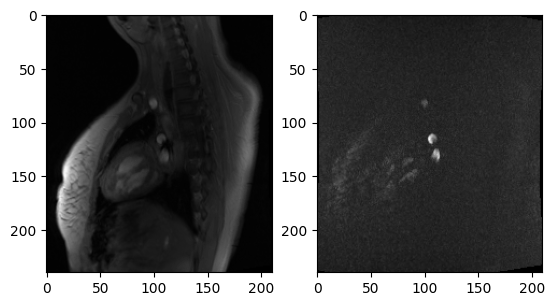

In [26]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(mag_series_df.image.values[0], 'gray')
axs[1].imshow(phase_series_df.image.values[0], 'gray')